# Chap05. 이미지 분류
## 1장의 내용을 개선하자! + 다양한 종류의 데이터에 적용해보자.
### 우리가 배워야 할 것들 (1) 여러 계층의 종류, (2) 정규화 방법, (3) 옵티마이저, (4) 한 구조에 여러 계층을 넣는 방법 등등.

# 5.1 개/고양이 예를 반려동물 품종으로 확장하기
##### 개/고양이 분류 -> 내 반려동물의 품종은?
#### 그렇다면 어떻게?
### 1. 어떤 데이터셋인지 제대로 알자!

In [1]:
from fastai.vision.all import *
path= untar_data(URLs.PETS)

### 일반적으로 데이터는 2가지 방식으로 제공된다.
#### (1) 개별 파일이 txt문서, img같은 개별 데이터 요소에 대응한다. 그리고 "폴더나 파일명에 각 데이터의 추가정보가 있다".
#### 
#### (2) 테이블 형식의 데이터로 제공된다.(CSV 파일 등) 각 행은 개별 데이터를 표현하고, 열 중에는 '파일명'을 담당하는 열이 있기도 하다. 파일명은 실제 txt문서나 img같은 데이터로 연결하는 역할을 한다.(링크로 저장한다는 의미)

##### 그렇다면 우리들의 데이터는 '어떻게 확인'할 수 있을까?

In [2]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

### 대충 여기서는 images만 확인.

In [3]:
(path/"images").ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_78.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_166.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_73.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_77.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_35.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_156.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_186.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_115.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_31.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_115.jpg')...]

### 많기도 해라... 우선, .ls()를 통해 얻어낸 출력물을 통해 images디렉토리의 구성이 어떻게 되는지 알아보자.
#### (1) L 클래스
##### - fastai 라이브러리 중 컬렉션을 반환하는 함수나 메서드(like .ls())는 대부분 L 클래스를 반환한다.
##### - list 자료형을 강화한 버전.
#### (2) (#7393)
##### - 컬렉션이 포함된 요소 개수.
##### - 7393개의 요소들이 있다.( = 데이터들이 있다.)
#### (3) [Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_78.jpg'), Path( ...
##### - Path 객체임을 알 수 있다.
##### - '/data'을 통해 데이터 임이 명시되어 있다.
##### - '/oxford-iiit-pet'을 통해 데이터를 제공한 기관이 명시되어 있다.
##### - '/images'를 통해 데이터 유형이 명시되어 있다.
##### - '/Bomay_78.jpg'를 통해 '품종_품종 당 몇 번째.jpg타입' 형식으로 데이터가 명시되어 있다.
#### 따라서, 우리는 **단순히 문자열을 ' _ ' 문자 기준으로 분리해서는 안된다!!**


#### 그렇다면 어떻게 해결해야 할까?
#### **!! 정규표현식 !!**


In [4]:
# 일단 하나 꺼내서 화인해보기
fname= (path/"images").ls()[0]

In [5]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Bombay']

#### * re는 정규표현식 regex를 축약한 말이다.
##### (정규표현식: regular expression -> regex -> re)
#### ** findall()은 정규표현식으로 나타낸 문자열을 전부 찾아내라는 의미인 것 같다.
#### *** r은 문자열의 우측부터 검사하라는 뜻인 듯하다.
##### (read라고 보기에는 정규표현식 자체가 문자열을 빠르게 검사 혹은 특정 문자열을 추출하기 위해 사용되기 때문에 굳이 read, write가 구분될 필요가 없다.)
#### **** (.+)는 우리가 국어적으로 알고 있듯 생략이 가능하다는 의미이다.
#### ***** _\d+.jpg$에서 _\d는 우리가 흔히 문자열에 int형 변수를 출력할 때 표현하는 방법과 같은 의미이다. 그리고, .jpg$를 보면 jpeg확장자를 명시했음을 알 수 있고, $는 문자열의 끝임을 나타내는 표현으로 보이며, +를 통해 두 표현식을 통합해 탐색하라는 의미인듯 하다.
#### , fname.name을 통해 /images 디렉토리 내의 형식을 갖춘 이름인 Bombay_78.jpg 등등을 검사하라고 명시해주었다.


In [6]:
pets= DataBlock(blocks= (ImageBlock, CategoryBlock),
                get_items= get_image_files,
                splitter= RandomSplitter(seed= 42),
                get_y= using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                item_tfms= Resize(460),
                batch_tfms= aug_transforms(size=224, min_scale= 0.75))
dls= pets.dataloaders(path/"images")

### dataloader를 통해 적재해야하는 fastai 특성상, dataloader를 커스텀하는 DataBlock내에서 정규표현식 사용이 가능하다.
#### get_y= using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name')
##### * get_y는 레이블(정답; 종속변수)를 지정하는 옵션이다.
##### ** using_attr()는 정확한 의미는 모르겠지만, 레이블 데이터들만 저장하기 위한 요소임은 확실하다. RegexLabeller(), 'name'을 통해 '카테고리명'을 명시했다.
##### *** RegexLabller [레젝스 라벨러]는 정규표현식을 통해 원하는 요소를 찾아내게 해주는 메소드이다.
#### 이번에 처음 확인되는 옵션들 item_tfms와 batch_tfms. 다음 절에서 무엇을 의미하는지 알아보자.

# 5.2 사전 크기 조절
#### 텐서로 포장된 "이미지를 GPU로 전달하려면 이미지가 **모두 같은 크기**여야 한다".
#### + 가능한 한 **적은 변형 작업**으로 데이터 증강을 수행할 것을 권장한다.
### ... 그런데... 데이터를 증강한다?
#### 데이터의 개수가 적은 경우, 데이터들을 추가 확보할 필요가 있다. 하지만, "새로운 데이터를 확보할 수 없는 경우, 기존의 이미지 데이터들을 **확대, 회전, 변형**한 후 복사하는 행위를 통해 추가 데이터들을 확보하는 과정"을 '데이터 증강'이라고 한다.
### ...음... 이미지 데이터를 확대, 회전, 변형 해 기존의 데이터를 뻥튀기하는 것은 좋다. 그런데, "오는게 있으면 가는게 있는법", 당연히 문제가 있다.
#### 예를 들어, **"확대"**
##### 너무 확대하면, '화질 저하'와 '추출 할 수 있는 특성의 축소' 등의 문제 등이 발생할 수 있다.
#### 또한, **"회전"**
##### 우로 한 45도 회전한다고 가정해보자, 기존 이미지 데이터를 단순히 45도 우로 회전하는 것이기 때문에, 특정 모퉁이 부분은 자동적으로 잘려나갈 것이다. 그리고 회전해 지나간 부분은 비어있을 것이다. 즉, 그만큼 추출할 수 있는 특성들이 줄어드는 것이다.
#### 마지막으로 **"변형"**
##### 의도적으로 이미지를 일그러뜨리는 것을 생각해보자. 과도한 일그러뜨림은 특성 추출에 혼란을 주어, 오히려 딥러닝 모델의 정확성을 떨어뜨릴 수 있다.
### 그렇다면 어떻게 해결할 수 있을까? **"보간법"**
#### 하지만, 보간법을 이용하면, 품질(화질)이 많이 떨어진다.
### 따라서 아래 방법의 순서로 보간을 수행한다.
#### (1) "이미지 크기를 상대적으로 '크게' 만든다. 실제로 원하는 이미지보다 훨씬 더 크게 만든다." 이는, 빈 영역을 만들지 않기 위함이다. 즉, 데이터 증강을 내부 영역에서 수행하도록 여분의 여백을 보장한다. 구체적으로는 정사각형으로 이미지 일부를 잘라내어 크기를 조절하는 방식을 적용한다. 참고로, 잘라낼 크기는 이미지 전체 너비와 높이 중 작은쪽이 선택된다.
#### (2) 이미지에 공통적으로 제공할 모든 증강 연산을 하나로 구성하고, 처리 마지막 단계에서 조합된 연산들을 GPU가 단 한 번만 수행한다. 이는, 개별 이미지에 증강 연산과 보간법을 수행하는 것과 대조된다. 즉, 일반적인 보간법은 증강 -> 보간, 다음 증강 -> 보간 이런 식이라면, 현재 순서는 증강, 증강, 증강, 증강, ... 증강 -> 보간 이런식이라고 생각하자.(나도 정확히는 모르겠다, 다만 여러번 보간하는 것보다 한번 보간하는게 좋다라는 매커니즘은 확실하다; 보간은 화질저하를 일으키니까...)
### 아니..., 그래서 이거 어떻게 쓰냐고...
#### 에헤이, 이제 설명할 것이다.
#### (1) item_tfms: 전체 너비나 높이를 기준으로 잘라내는 단계
##### - item_tfms= Resize(460). GPU로 복사되기 전 개별 이미지에 적용된다.
##### - 이 단계를 통해 모든 이미지를 같은 크기로 만들어준다.
##### - 학습용 데이터셋에는 잘릴 영역이 임의로 정해진다.
##### - 검증용 데이터셋에는 항상 이미지의 정중앙 정사각형 영역이 선택된다.
#### (2) batch_tfms: 임의의 부분을 잘라낸 후 증강하는 단계
##### - batch_tfms= aug_transforms(size=224, min_scale= 0.75)
##### - GPU에서 한 번에 처리할 배치 단위의 데이터에 적용되어 빠르게 처리된다.
##### - 학습용 데이터셋에서는 임의로 잘라내는 작업을 포함한 다른 증강 연산을 먼저 수행한다.
##### - 검증용 데이터셋에서는 모델에 필요한 최종 크기로 조절하는 작업만 수행한다.
### 정리하자면,
#### (1)에서는 Resize를 통한 "요소 변환"을,(대신에 pad나 squish를 사용해도 된다.)
#### (2)에서는 RandomResizedCrop을 이용한 "배치 변환"을 사용해야하지만, aug_transforms 함수에서 min_scale 인잣값ㅇ르 조절해서도 RandomResizedCrop을 적용해냈다.
### 최종적으로 **"사전 크기 조절"**은 학습 속도를 높일 뿐만 아니라 모델의 정확도 개선에도 매우 유용한 기법이다.

# 5.2.1 데이터 블록 검사와 디버깅
#### !! 항상 !! 학습시키기 전, 데이터블럭이 **정상적으로 작동하는지** 점검해야 한다.
### Use this! show_batch()

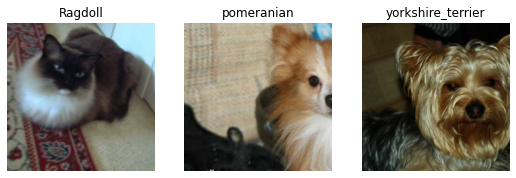

In [7]:
dls.show_batch(nrows=1, ncols=3)

#### !! 잠깐 !! show_batch는 이미지와 레이블이 잘 맞춰서 설정이 되었는지 확인하는 과정이다. 우리는 데이터블록이 잘 구축되었는지 파악해야한다!
### Use this! summary()

In [8]:
pets1= DataBlock(blocks= (ImageBlock, CategoryBlock),
                 get_items= get_image_files,
                 splitter= RandomSplitter(seed=42),
                 get_y= using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
# !!!Watch this!!!
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_101.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=480x360
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_101.jpg
    applying partial gives
      Egyptian_Mau
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(5)

Final sample: (PILImage mode=RGB size=480x360, TensorCategory(5))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up afte

RuntimeError: ignored

#### 오류가 발생했다면, 제대로 작성한 것이다. 현재 pets1에서 우리는 이미지 데이터의 사이즈를 재조정하는 것을 잊어버리는 중대한 실수를 저지른 것이다.

### 1장에서처럼 resnet34 모델을 이용해 지표를 확인해 보자..

In [9]:
learn= vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.509534,0.342411,0.106225,01:17


epoch,train_loss,valid_loss,error_rate,time
0,0.493787,0.299157,0.096076,01:14
1,0.341347,0.231709,0.071042,01:16
